 #  Flight Delay Prediction using Random Forest

## Problem introduction

The problem we will tackle is predicting the arrival delay of a flight. We are going to face it as a Regression problem, in which our goal is to predict the exact delay of a flight in minutes.

In [1]:
import numpy as np
import pandas as pd
import sklearn

The following code loads in the csv data and displays the structure of the data.

In [2]:
normal_data = pd.read_csv('/Users/vasilgeorge/Documents/Datatonic Data Challenge/data/flights_small.csv')

print (normal_data.head(5))

         Date Airline  Airline_code Arrival_airport Arrival_state  \
0  2003-04-05      EV         20366             SHV            LA   
1  2006-04-10      YV         20378             CLT            NC   
2  2006-04-05      YV         20378             CLT            NC   
3  2006-01-12      YV         20378             CLT            NC   
4  2006-01-05      YV         20378             CLT            NC   

  Departure_Airport Departure_State  Departure_actual  Departure_delay  \
0               MOB              AL              1820              -10   
1               MGM              AL              1613              -10   
2               MGM              AL              1615               -8   
3               MGM              AL              1620               -3   
4               MGM              AL              1614                0   

   Arrival_actual  Arrival_delay  Arrival_schedule  Departure_schedule  \
0            2048             30              2018                

## Identify anomalies in the data

To identify anomalies, we can quickly compute summary statistics.

In [3]:
normal_data.describe()

,Airline_code,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Path_order
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0
mean,20107.987560,1321.480030,7.101480,1474.252330,4.983180,1481.637740,1316.376930,-93.641310,36.892385,-93.641310,36.892385,1.0
std,348.397732,476.695954,28.895134,491.533272,31.955826,475.366186,465.210279,16.093128,4.972927,16.093128,4.972927,0.0
min,19386.000000,1.000000,-32.000000,1.000000,-83.000000,1.000000,9.000000,-159.330000,18.430000,-159.330000,18.430000,1.0
25%,19790.000000,915.000000,-5.000000,1052.000000,-11.000000,1057.000000,915.000000,-106.600000,33.630000,-106.600000,33.630000,1.0
50%,20355.000000,1318.000000,-1.000000,1506.000000,-3.000000,1510.000000,1315.000000,-87.900000,37.500000,-87.900000,37.500000,1.0
75%,20374.000000,1722.000000,5.000000,1859.000000,9.000000,1855.000000,1715.000000,-81.300000,40.630000,-81.300000,40.630000,1.0
max,21171.000000,2400.000000,947.000000,2400.000000,948.000000,2359.000000,2359.000000,-66.000000,47.450000,-66.000000,47.450000,1.0


## Data Preparation

In order to use the data we have for training, we first have to bring some of the features into a form recognizable by the computer. At first, we split the 'Date' column into 'Year', 'Month' and 'Day'.

In [4]:
normal_data['Year']=[d.split('-')[0] for d in normal_data.Date]
normal_data['Month']=[d.split('-')[1] for d in normal_data.Date]
normal_data['Day']=[d.split('-')[2] for d in normal_data.Date]
normal_data.drop('Date', inplace=True, axis=1)
print (normal_data.head(1))

  Airline  Airline_code Arrival_airport Arrival_state Departure_Airport  \
0      EV         20366             SHV            LA               MOB   

  Departure_State  Departure_actual  Departure_delay  Arrival_actual  \
0              AL              1820              -10            2048   

   Arrival_delay ...  Departure_schedule  DC_Longitude  DC_Latitude  \
0             30 ...                1830        -88.24        30.69   

   Longitude  Latitude     Route Path_order  Year Month Day  
0     -88.24     30.69  AL to LA          1  2003    04  05  

[1 rows x 21 columns]


At this point, we realize that we can compute the distance between two airports, since we have the longitude and latitude of each airport. We can do this by using the haversine distance. After we have computed this distance, we can add this distance as a new feature that is going to be used for training.

In [5]:
import math
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

coordinates = {}
normal_data['Distance'] = 0
for i in range(normal_data.shape[0]):
    coordinates[normal_data['Departure_State'].iloc[i]] = (normal_data['Longitude'].iloc[i], normal_data['Latitude'].iloc[i])

for i in range(normal_data.shape[0]):
    lat1 = normal_data['Latitude'].iloc[i]
    lon1 = normal_data['Longitude'].iloc[i]
    lat2 = coordinates[normal_data['Departure_State'].iloc[i]][1]
    lon2 =  coordinates[normal_data['Departure_State'].iloc[i]][0]
    
    normal_data['Distance'].loc[i] = distance(lat1, lon1, lat2, lon2) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


At this point we are going to get rid of all the features that we are not going to use in the training of the Random Forest.

In [6]:
normal_data.drop('Airline', inplace=True, axis=1)
normal_data.drop('Departure_State', inplace=True, axis=1)
normal_data.drop('Arrival_state', inplace=True, axis=1)
normal_data.drop('Departure_actual', inplace=True, axis=1)
normal_data.drop('Arrival_actual', inplace=True, axis=1)
normal_data.drop('DC_Longitude', inplace=True, axis=1)
normal_data.drop('DC_Latitude', inplace=True, axis=1)
normal_data.drop('Longitude', inplace=True, axis=1)
normal_data.drop('Latitude', inplace=True, axis=1)
normal_data.drop('Route', inplace=True, axis=1)
normal_data.drop('Path_order', inplace=True, axis=1)

At this step we have to one-hot encode our data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering. In our example, we are going to one-hot encode the 'Arrival airport' and 'Departure airport' features.

In [7]:
normal_data = pd.get_dummies(normal_data, columns=['Arrival_airport', 'Departure_Airport'])

normal_data.head(1)

,Airline_code,Departure_delay,Arrival_delay,Arrival_schedule,Departure_schedule,Year,Month,Day,Distance,Arrival_airport_ATL,...,Departure_Airport_SFO,Departure_Airport_SJU,Departure_Airport_SLC,Departure_Airport_SNA,Departure_Airport_SRQ,Departure_Airport_STL,Departure_Airport_TPA,Departure_Airport_TUL,Departure_Airport_TUS,Departure_Airport_XNA
0,20366,-10,30,2018,1830,2003,04,05,250.623108,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#Verify that the one-hot encoding was correct.
normal_data.iloc[:,:].head(1)

,Airline_code,Departure_delay,Arrival_delay,Arrival_schedule,Departure_schedule,Year,Month,Day,Distance,Arrival_airport_ATL,...,Departure_Airport_SFO,Departure_Airport_SJU,Departure_Airport_SLC,Departure_Airport_SNA,Departure_Airport_SRQ,Departure_Airport_STL,Departure_Airport_TPA,Departure_Airport_TUL,Departure_Airport_TUS,Departure_Airport_XNA
0,20366,-10,30,2018,1830,2003,04,05,250.623108,0,...,0,0,0,0,0,0,0,0,0,0


## Features and Targets and Convert Data to Arrays

Now we need to separate the data into features and targets. The target, also known as the label, is the value we want to predict, in this case the actual arrival delay and the features are all the columns the model uses to make a prediction.

In [9]:
labels = np.array(normal_data['Arrival_delay'])
features = normal_data.drop('Arrival_delay', axis=1)
feature_list = list(features.columns)
features = np.array(features)

At this step we split our dataset into training and testing dataset. The training dataset is used to train the random forest model, while we are using the testing dataset to evaluate the performance of the model.

In [10]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                           random_state=42)

We inspect the data to verify that the split was correct.

In [11]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (75000, 126)
Training Labels Shape: (75000,)
Testing Features Shape: (25000, 126)
Testing Labels Shape: (25000,)


## Training

After all the work of data preparation, creating and training the model is pretty simple using Scikit-learn. We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Make predictions

Our model has now been trained to learn the relationships between the features and the targets. The next step is figuring out how good the model is. To do this we make predictions on the test features. We then compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value . 

In [13]:
predictions = rf.predict(test_features)

errors = abs(predictions-test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'minutes.')

Mean Absolute Error: 8.93 minutes.


## Determine performance metrics

To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [14]:
average_test_label = np.average(test_labels)
mape = 100 * (errors / average_test_label)
accuracy = abs(100 - np.mean(mape))
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 73.31 %.


## Variable importances

In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. 

In [15]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Departure_delay      Importance: 0.84
Variable: Arrival_schedule     Importance: 0.02
Variable: Departure_schedule   Importance: 0.02
Variable: Month                Importance: 0.02
Variable: Day                  Importance: 0.02
Variable: Airline_code         Importance: 0.01
Variable: Year                 Importance: 0.01
Variable: Distance             Importance: 0.0
Variable: Arrival_airport_ATL  Importance: 0.0
Variable: Arrival_airport_BOS  Importance: 0.0
Variable: Arrival_airport_CLT  Importance: 0.0
Variable: Arrival_airport_COU  Importance: 0.0
Variable: Arrival_airport_CVG  Importance: 0.0
Variable: Arrival_airport_CYS  Importance: 0.0
Variable: Arrival_airport_DAB  Importance: 0.0
Variable: Arrival_airport_DEN  Importance: 0.0
Variable: Arrival_airport_PDX  Importance: 0.0
Variable: Arrival_airport_PHL  Importance: 0.0
Variable: Arrival_airport_PHX  Importance: 0.0
Variable: Arrival_airport_PIT  Importance: 0.0
Variable: Arrival_airport_PNS  Importance: 0.0
Variab

We can see that the most important feature by far is the departure delay. In our next step, we will try to train our Random Forest model without using the departure delay feature. As we can see, the results are disappointing.

In [17]:
features_rest = normal_data.drop('Arrival_delay', axis=1)
features_rest = normal_data.drop('Departure_delay', axis=1)
feature_list_rest = list(features_rest.columns)
features_rest = np.array(features_rest)

train_features_rest, test_features_rest, train_labels_rest, test_labels_rest = train_test_split(features_rest, labels, test_size=0.25,
                                                                           random_state=42)

rf_rest = RandomForestRegressor(n_estimators=1000, random_state=42)

rf_rest.fit(train_features_rest, train_labels_rest)

predictions_rest = rf.predict(test_features_rest)

errors_rest = abs(predictions_rest-test_labels_rest)

print('Mean Absolute Error:', round(np.mean(errors_rest), 2), 'minutes.')

average_test_label_rest = np.average(test_labels_rest)
mape_rest = 100 * (errors_rest / average_test_label_rest)
accuracy_rest = abs(100 - np.mean(mape_rest))
print('Accuracy:', round(accuracy_rest, 2), '%.')

Mean Absolute Error: 3.3 minutes.
Accuracy: 35.89 %.


Now, we are going to use just the 5 most importan features to train the Random Forest, since out of the 126 features, only 7 of them had some weight. As a result, there is no point in using all of them.

In [20]:
features_imp = normal_data.drop('Arrival_delay', axis=1)
features_imp = normal_data[['Departure_delay', 'Arrival_schedule', 'Departure_schedule', 'Month', 'Day']]
feature_list_imp = list(features_imp.columns)
features_imp = np.array(features_imp)

train_features_imp, test_features_imp, train_labels_imp, test_labels_imp = train_test_split(features_imp, labels, test_size=0.25,
                                                                           random_state=42)

rf_imp = RandomForestRegressor(n_estimators=1000, random_state=42)

rf_imp.fit(train_features_imp, train_labels_imp)

predictions_imp = rf_imp.predict(test_features_imp)

errors_imp = abs(predictions_imp-test_labels_imp)

print('Mean Absolute Error:', round(np.mean(errors_imp), 2), 'minutes.')

average_test_label_imp = np.average(test_labels_imp)
mape_imp = 100 * (errors_imp / average_test_label_imp)
accuracy_imp = abs(100 - np.mean(mape_imp))
print('Accuracy:', round(accuracy_imp, 2), '%.')

Mean Absolute Error: 9.3 minutes.
Accuracy: 80.57 %.


We can observe a rise in the accuracy when using only 5 of the features, compared to the case where we used all 126 features.

## Visualization

The following chart is a simple bar plot of the 5 most important features in order to illustrate the disparities in the relative significance of the variables.

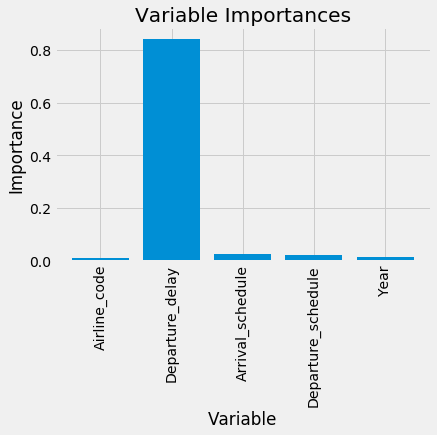

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('fivethirtyeight')

x_values = list(range(len(importances[:5])))
plt.bar(x_values, importances[:5], orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); 
plt.title('Variable Importances');